## TD Models

TD-learning family models:
1. <a href='#oneStepSARSA'> One-step SARSA </a>
2. n-step SARSA
3. Actor-critic:
    * Some Theory: <a href='http://incompleteideas.net/book/first/ebook/node66.html'>Actor-Critic Methods</a>
    * Possible Implementation: <a href='https://www.nature.com/articles/s41598-017-18004-7'> A hippocampo-cerebellar centred network for the learning and execution of sequence-based navigation </a>

In [1]:
# Imports
from __future__ import print_function
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys

module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Some lists of nicknames for mice
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [3]:
# Define cell numbers of end/leaf nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}

### One-step SARSA <a id='#oneStepSARSA'></a>
Online TD-control algorithm which estimates state-action values, Q(s,a)
 - States: 127 maze nodes
 - Actions: 3 actions for each state (except for end nodes)
 - Rewards: 0 on all states except for 1 on the water port

Pseudocode
- Softmax action selection
- Action-value update: $Q(s,a) \leftarrow Q(s,a) + \alpha*(R + \gamma*R' - Q(s',a'))$

In [4]:
def get_SAnodemap(S,A):
    '''
    Generate an array with the same dimensions as state-action value table but with entries as node labels
    '''
    SAnodemap = np.ones((S+1,A)) * np.nan
    for node in np.arange(S):
        # Shallow level node available from current node
        if node%2 == 0:
            SAnodemap[node,0] = (node - 2) / 2
        elif node%2 == 1:
            SAnodemap[node,0] = (node - 1) / 2
        if SAnodemap[node,0] == -1:
            SAnodemap[node,0] = 127
        
        if node not in lv6_nodes:
            # Deeper level nodes available from current node
            SAnodemap[node,1] = node*2 + 1
            SAnodemap[node,2] = node*2 + 2
    
    # Nodes available from entry point
    SAnodemap[127,0] = np.nan
    SAnodemap[127,1] = 0
    SAnodemap[127,2] = np.nan
    
    return SAnodemap

In [5]:
# Set environment parameters
S = 127
A = 3
RT = 1
Q_nodemap = get_SAnodemap(S,A)

# Set model parameters
alpha = 0.5  # learning rate
gamma = 0.9
beta = 20  # softmax exploration - exploitation
N = 500  # number of episodes to train over

# Initialize model parameters
Q = np.random.rand(S+1,A)  # state-action values
Q[127,:] = 0  # setting action-values of reward port to 0
Q[np.isnan(Q_nodemap)] = np.nan
state_hist_all = {}
total_reward = 0

for n in np.arange(N):
    # Initialize starting state,s0 to node 0 and selection action a0
    aprob = []
    choices = []
    s = 0
    for atype in np.arange(3):
        aprob.extend([np.exp(beta*Q[s,atype])/np.nansum(np.exp(beta*Q[s,:]))])
    a = np.random.choice([0,1,2],1,p=aprob)[0]
    state_hist = []
    
    # Begin episode
    while s!=127:
        # Record current state
        state_hist.extend([s])
        
        # Take action, observe reward and next state
        sprime = int(Q_nodemap[s,a])
        if sprime == 116:
            R = 1  # Receive a reward of 1 when transitioning to the reward port
            total_reward += 1
        else:
            R = 0
            
        # Choose next action, aprime from new state, sprime
        aprob = []
        choices = []
        for atype in np.arange(3):
            if not np.isnan(Q[sprime,atype]):
                aprob.extend([np.exp(Q[sprime,atype])/np.nansum(np.exp(Q[sprime,:]))])
                choices.extend([atype])
        aprime = np.random.choice(choices,1,p=aprob)[0]
        
        # Update action-value of previous state-action pair, Q[s,a]
        Q[s,a] += alpha * (R + gamma*Q[sprime,aprime] - Q[s,a])
        
        # Shift state and action values for the next time step
        a = aprime
        s = sprime
    state_hist.extend([s])
    state_hist_all[n] = state_hist

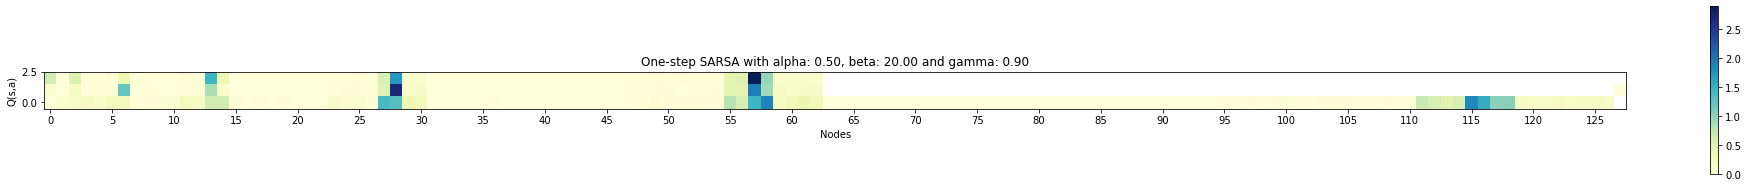

In [41]:
# Plotting state-action values
fig, ax = plt.subplots(figsize=(30,800))
axhandle = ax.imshow(np.transpose(Q),cmap='YlGnBu')
ax.invert_yaxis()
ax.set_ylabel('Q(s,a)')
ax.set_xticks(np.arange(0,127,5))
ax.set_xticklabels([str(val) for val in np.arange(0,127,5)])
ax.set_xlabel('Nodes')
ax.set_title('One-step SARSA with alpha: %.2f, beta: %.2f and gamma: %.2f' %(alpha,beta,gamma))
fig.colorbar(axhandle,fraction=0.005)